# 5. Étude des modèles

Dans cette partie nous allons étudier les 3 modèles que nous avons retenus pour ce projet.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

main_dataset = pd.read_excel("./buffer/1-main_dataset.xlsx")
main_dataset.drop(columns=main_dataset.columns[0], axis=1, inplace=True)

In [3]:
X = main_dataset.drop(columns="Attrition", axis=1)
y = [i == "Yes" for i in main_dataset["Attrition"]]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,  random_state=0)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_dict = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 5}, max_depth=30, min_samples_leaf= 3, min_samples_split=2, n_estimators=130),
    'Logistic Regression': LogisticRegression(C=0.15, penalty="l2"),
    'Multi Layered Perceptron': MLPClassifier(random_state=42, alpha=0.1, hidden_layer_sizes=100, max_iter=1600, solver='lbfgs')
}

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
      transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

full_pipeline_dict = {}
for name, model in model_dict.items():
      full_pipeline_dict[name] = Pipeline(steps=[
            ('preprocessor', preprocessor),
            (name, model)])

Ces 3 modèles ont été retenues pour leurs scores élevés et leurs fonctionalités

In [6]:
for name, pipeline in full_pipeline_dict.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} score: {score}")

Random Forest score: 0.9807256235827665
Logistic Regression score: 0.8503401360544217
Multi Layered Perceptron score: 0.9909297052154195


## 1. Random Forest

Le modèle Random Forest nous permet de récupérer une valeur intéressante: feature_importances_

Ces valeurs nous permet de savoir quel paramètre influe le plus sur l'attrition

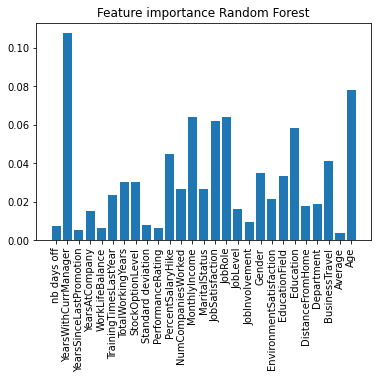

In [7]:
feature_importance = model_dict['Random Forest'].feature_importances_
feature_importance = {X_train.columns[i]: feature_importance[i] for i in range(len(X_train.columns))}
feature_importance = dict(sorted(feature_importance.items(), reverse=True))

graph_l = feature_importance.keys()
y_pos = np.arange(len(graph_l))
graph_x = feature_importance.values()

#ax = axs[i].add_axes([0,0,1,1])
plt.bar(y_pos, graph_x)
plt.xticks(y_pos, labels=graph_l, rotation=90)
plt.title('Feature importance Random Forest')

plt.show()

## 2. Régression Logistique

Le modèle linéaire de régression logistique nous permet de récupérer une valeur intéressantes: coef_

Comme le modèle est linéaire, la relation entre les paramètres d'entrée et de sortie sont liés de façon linéaire.

Cela nous permet donc de savoir dans quel sens un paramètre doit être shifté pour améliorer l'Attrition

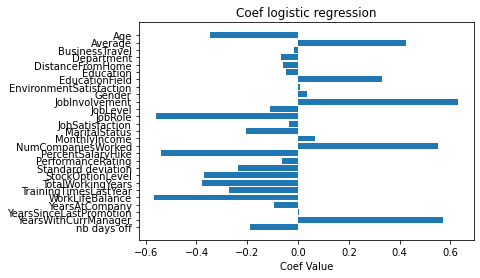

In [8]:
feature_importance = model_dict['Logistic Regression'].coef_[0]
feature_importance = {X_train.columns[i]: feature_importance[i] for i in range(len(X_train.columns))}
feature_importance = dict(sorted(feature_importance.items(), reverse=True))

graph_l = feature_importance.keys()
y_pos = np.arange(len(graph_l))
graph_x = feature_importance.values()

plt.barh(y_pos, graph_x)
plt.yticks(y_pos, labels=graph_l)
plt.xlabel('Coef Value')
plt.title('Coef logistic regression')

plt.show()

## 3. Modèle Multi-layered Perceptron

Le modèle du perceptron multicouche est le plus performant mais il n'a aucune fonctionalité nous permettant de trouver comment améliorer les variables d'entrée.

Pour pouvoir savoir comment améliorer cela, nous avons créer un script qui va shifter les valeurs d'une colonne du minimum vers le maximum afin de récupérer le meilleur offset.

In [9]:
def variation(model: Pipeline, X: pd.DataFrame, param: str, divi = 30):
    global y_predicted
    # Copy of the datasets for translating the values
    X = X.copy()

    # Finding the translation amount
    maxi = max(X[param])
    mini = min(X[param])
    alpha = ( (maxi-mini) - (mini-maxi) ) / divi

    y_score = sum(y_predicted) * 100 / len(y_predicted)
    best_score = (y_score, 0)
    for delta in np.arange(mini-maxi, maxi-mini, alpha):
        # Translating the parameter
        X_for = X.copy()
        X_for[param] += np.array( [delta] * len(X_for[param]) )

        # Flooring and ceilling the parametes
        X_for[param].where(X_for[param] < maxi, maxi, inplace=True)
        X_for[param].where(X_for[param] > mini, mini, inplace=True)

        # Get the prediciton with the new model
        y_local_predicted = model.predict(X_for)

        # Get the number of peaple that attritioned
        y_local_score = sum(y_local_predicted) * 100 / len(y_local_predicted)
        reldelta = delta/(maxi-mini)

        if y_local_score < best_score[0]:
            best_score = ( y_local_score, reldelta )

    return best_score

In [10]:
y_predicted = full_pipeline_dict['Multi Layered Perceptron'].predict(X_test)

dict_var = {}
for column in numeric_features:
    dict_var[column] = variation(full_pipeline_dict["Multi Layered Perceptron"], X_test, column)

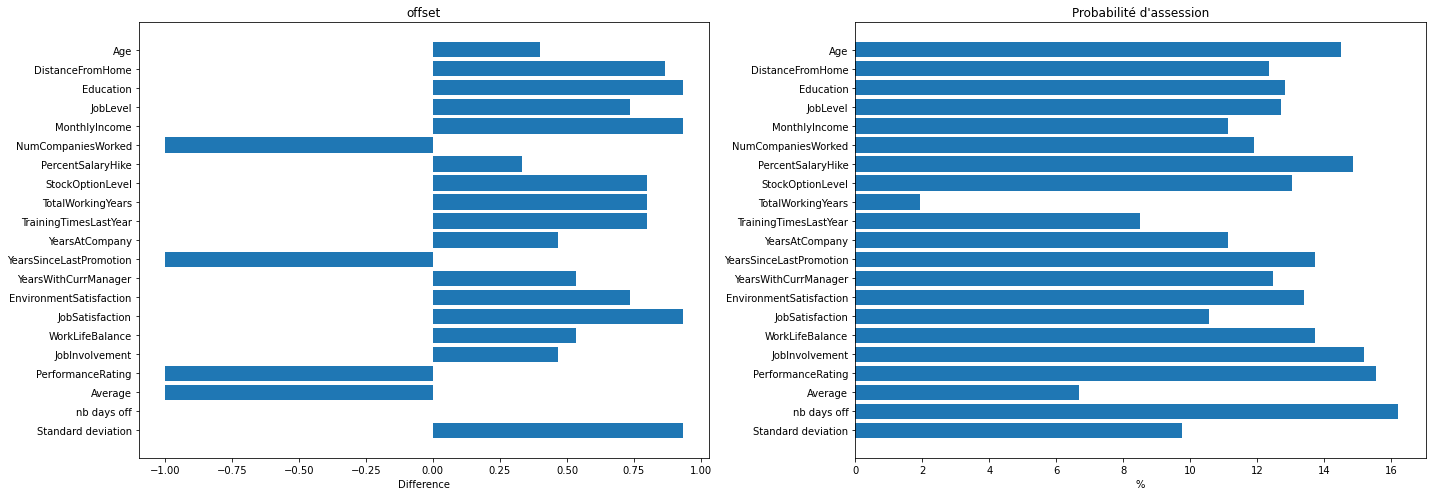

In [11]:
graph_l = dict_var.keys()
y_pos = np.arange(len(graph_l))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

graph1_x = {k: v[1] for k, v in dict_var.items()}.values()
#ax = axs[i].add_axes([0,0,1,1])
ax1.barh(y_pos, graph1_x)
ax1.set_yticks(y_pos, labels=graph_l)
ax1.invert_yaxis()
ax1.set_xlabel('Difference')
ax1.set_title('offset')

graph2_x = {k: v[0] for k, v in dict_var.items()}.values()
#ax = axs[i].add_axes([0,0,1,1])
ax2.barh(y_pos, graph2_x)
ax2.set_yticks(y_pos, labels=graph_l)
ax2.invert_yaxis()
ax2.set_xlabel('%')
ax2.set_title('Probabilité d\'assession')

fig.tight_layout()

Nous pouvons voir dans le graphique que les paramètres diminuant le plus l'attrition est le `TotalWorkingYears` suivit du `Average` (temps de travail moyens) puis du `TrainingTimesLastYears`.

Réalistiquement nous ne pouvons pas influer sur `TotalWorkingYears` mais nous apprenons que diminuer le temps de travail moyen et augmenter le temps de formation de l'année passée sont les deux paramètres les plus pertinents à modifier.